# Load libraries

In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
from sklearn import svm
import random
import pandas as pd
import time
import math
import statistics
from jupyterplot import ProgressPlot
#time.sleep(3) # sleep 3 second
from scipy.interpolate import interp1d 
from icecream import ic
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import pywt
import wfdb
import seaborn as sns
import heartpy as hp
import neurokit as nk
import neurokit2 as nk2
import biosppy
from numbers import Number

plt.rcParams["figure.figsize"] = (20,6)

# Functons

In [2]:
def calculate_median(ecg):
    V= 60
    data = ecg.copy()
    n = len(data)
    if (n<V):
        return np.median(data)*np.ones(len(data))
    
    width = int(V/2)
    
    m1 = np.ones(width)*np.median(data[0:width])
    m2 = np.ones(width)*np.median(data[n-width:n])
    
    m = np.zeros((V,n-V))
    
    m[0,:] = data[0:n-V]
    #print(m)
    
    for i in range(0,V):
        m[i,:] = data[i:n-V+i]
        
    #print(m)
    m=np.median(m,  axis=0)
    
    y = np.append(m1,m)
    y = np.append(y,m2)
    #print("--------------")
    #print(m)
    
    return y

In [3]:
def medianf(ecg):
    data = ecg.copy()
    m = calculate_median(ecg)
    return data - m

In [4]:
def scale_data(d):
    V= 512*3
    data = abs(d.copy())
    n = len(data)
    
    if (n<V):
        return data / np.max(data)
    
    width = int(V/2)
    
    m1 = np.ones(width)*np.max(data[0:width])
    m2 = np.ones(width)*np.max(data[n-width:n])
    
    m = np.zeros((2,n-V))
    
    #m = np.zeros((V,n-V))
    #m[0,:] = data[0:n-V]
    #print(m)
    
    #ic(data)
    #ic(len(data)-V)
    
    h = abs(data[0:n-V])
    #ic(h)
    #ic(len(h))
    #ic(m)
    #ic(len(m[0]))
    for i in range(1,V):
        m[0,:] = h
        m[1,:] = abs(data[i:n-V+i])
        h = np.max(m,axis=0) 
        
    #print(m)
    k = 1 # 0.75
    m= k*np.max(m,  axis=0)
    
    y = np.append(m1,m)
    y = np.append(y,m2)
    #print("--------------")
    #print(m)
    
    y = data / y
    
    return y


In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    #idx = (np.abs(array - value)).argmin()
    
    idx = np.array([])
    for v in value:
        i = (np.abs(array - v)).argmin()
        idx = np.append(idx,i)
    #return array[idx]
    return idx

# Load data

In [6]:
ecg_data = pd.read_csv("ecg_db02.csv",delimiter=";")
ecg1 = ecg_data[ecg_data['dev_id']==1]
ecg1 = ecg1.sort_values(by=['org_timestamp'])
ecg2 = ecg_data[ecg_data['dev_id']==2]
ecg2 = ecg2.sort_values(by=['org_timestamp'])
ecg3 = ecg_data[ecg_data['dev_id']==3]
ecg3 = ecg3.sort_values(by=['org_timestamp'])

t_ecg1 = ecg1['org_timestamp'].to_numpy()
t_ecg2 = ecg2['org_timestamp'].to_numpy()
t_ecg3 = ecg3['org_timestamp'].to_numpy()
ic(len(t_ecg1))
ic(len(t_ecg2))
ic(len(t_ecg3))

timestamp_ecg1 = ecg1['timestamp'].to_numpy()
timestamp_ecg2 = ecg2['timestamp'].to_numpy()
timestamp_ecg3 = ecg3['timestamp'].to_numpy()
ic(len(timestamp_ecg1))
ic(len(timestamp_ecg2))
ic(len(timestamp_ecg3))


ecg1 = ecg1['data'].to_numpy()
ecg2 = ecg2['data'].to_numpy()
ecg3 = ecg3['data'].to_numpy()
ic(len(ecg1))
ic(len(ecg2))
ic(len(ecg3))

ic| len(t_ecg1): 3226528
ic| len(t_ecg2): 3234656
ic| len(t_ecg3): 3234768
ic| len(timestamp_ecg1): 3226528
ic| len(timestamp_ecg2): 3234656
ic| len(timestamp_ecg3): 3234768
ic| len(ecg1): 3226528
ic| len(ecg2): 3234656
ic| len(ecg3): 3234768


3234768

In [10]:
acceleration_data = pd.read_csv("accelerationmeter_db02.csv",delimiter=";")
acceleration_data = acceleration_data.sort_values(by=['timestamp'])
t_acc = acceleration_data['org_timestamp'].to_numpy()
timestamp_acc = acceleration_data['timestamp'].to_numpy()
x_acc           = acceleration_data['data_x']
y_acc           = acceleration_data['data_y']
z_acc           = acceleration_data['data_z']


gyro_data = pd.read_csv("gyroscope_db02.csv", delimiter=";")
gyro_data = gyro_data.sort_values(by=['timestamp'])
t_gyro = gyro_data['org_timestamp'].to_numpy()
timestamp_gyro   = gyro_data['timestamp'].to_numpy()
x_gyro           = gyro_data['data_x']
y_gyro           = gyro_data['data_y']
z_gyro           = gyro_data['data_z']


#magn_data = pd.read_csv("magnetometer_db02.csv", delimiter=";")
#magn_data = magn_data.sort_values(by=['timestamp'])
#t_magn = magn_data['org_timestamp'].to_numpy()
#timestamp_magn   = magn_data['timestamp'].to_numpy()
#x_magn           = magn_data['data_x']
#y_magn           = magn_data['data_y']
#z_magn           = magn_data['data_z']

In [11]:
t = t_ecg1[t_ecg1 % 1000 == 0]
fs = int( np.where(t_ecg1==t[1])[0] - np.where(t_ecg1==t[0])[0] ) 

print("frames per second", fs)

frames per second 640


# Check holes in the data

Lets first separate ecg datas if there are 10 second pause between data points. Then we will study information of these time intervals. 

In [12]:
df = 10000 # = 10 seconds

In [13]:
def processTime(t_ecg, timestamp_ecg, df=5000):
    n = len(t_ecg)
    t_diff = t_ecg[1:n] - t_ecg[0:n-1]
    t_diff = np.append([0], t_diff)

    #timestamp_diff = timestamp_ecg[1:n] - timestamp_ecg[0:n-1]
    #timestamp_diff = np.append([0], timestamp_diff)
    
    index = (t_diff>=df)*np.arange(0,n)
    index = index[index>0]
    
    #index = (timestamp_diff>=df)*np.arange(0,n)
    #index = index[index>0]
    #print(len(index))
    
    if ( len(index) <= 0) :
        t_data = list([t_ecg])
        timestamp_data = list([timestamp_ecg])
        return [t_data, timestamp_data]


    t_data = list()
    timestamp_data = list()

    a = 0
    for i in index:
        t_data.append(t_ecg[a:i-1])
        timestamp_data.append(timestamp_ecg[a:i-1])

        a = i
    
    t_data.append(t_ecg[a:n])
    timestamp_data.append(timestamp_ecg[a:n])
    
    return [t_data, timestamp_data]

process timeintervals and return list of timeseries where are over 10 seconds hole.

In [15]:
[t_e1, timestamp_e1] = processTime(t_ecg1, timestamp_ecg1, df)
[t_e2, timestamp_e2] = processTime(t_ecg2, timestamp_ecg2, df)
[t_e3, timestamp_e3] = processTime(t_ecg3, timestamp_ecg3, df)
[t_a, timestamp_a] = processTime(t_acc, timestamp_acc, df)
[t_g, timestamp_g] = processTime(t_gyro, timestamp_gyro, df)
#[t_m, timestamp_m] = processTime(t_magn, timestamp_magn, df)


In [16]:
#t_data = list([t_e1,t_e2,t_e3, t_a, t_g, t_m])
#timestamp_data = list([timestamp_e1, timestamp_e2, timestamp_e3, timestamp_a, timestamp_g, timestamp_m])

t_data = list([t_e1,t_e2,t_e3, t_a, t_g])
timestamp_data = list([timestamp_e1, timestamp_e2, timestamp_e3, timestamp_a, timestamp_g])

Gather all the begins and end of time intervals

In [17]:
t_beg = np.array([])
t_end = np.array([])

for device in range(0,3):
    #print("device id: ", i+1)
    for j in range(0,len(t_data[device])):
        m = len(t_data[device][j])
        t_beg = np.append(t_beg, timestamp_data[device][j][0])
        t_end = np.append(t_end, timestamp_data[device][j][m-1])
        
        print(timestamp_data[device][j][0], " -- ", timestamp_data[device][j][m-1])
                
t_beg.sort()
t_end.sort()
#ic(t_beg)
#ic(t_end)


1624881394612  --  1624892262170
1624892696441  --  1624892262207
1624892696869  --  1624892262160


Check those intervals and combine them.

In [18]:
i=0
j=0
add_len = 0

time_beg = list()
time_end = list()

while i<len(t_beg) and j<len(t_end):
    #ic(t_beg[i])
    
    index = (t_beg>=(t_beg[i]-df)) * (t_beg <= (t_beg[i] + df))
    t_b = t_beg[index==True]
    
    index = (t_end>=(t_end[i]-df)) * (t_end <= (t_end[i] + df))
    t_e = t_end[index==True]
    
    
    if ( len(t_b)>0 and len(t_e)>0):
        a = np.max(t_b)
        b = np.min(t_e)
        
        
        if add_len>0 and b < time_beg[add_len-1]:
            j = j + len(t_e)
        elif add_len>0 and a < time_end[add_len-1]:
            i = i + len(t_b)
        else:
            print( a, " -- ", b)

            time_beg.append(a)
            time_end.append(b)

            add_len = add_len + 1
            i = i + len(t_b)
            j = j + len(t_e)
            
    else:
        i = i + 1
        j=j+1
#ic(time_beg)
#ic(time_end)
t_b = None
t_e = None

1624881394612.0  --  1624892262160.0


In [19]:
# Make some space to memory
t_e1 = None
t_e2 = None
t_e3 = None
timestamp_e1 = None
timestamp_e2 = None
timestamp_e3 = None

# Syncronize data

Now that we have calculated the time intervals begin and end times, so now we can start to synchronize the data 

In [22]:
A=5000
df = 5000
fs=512
upper_limit = 250
lower_limit = -1 * upper_limit
show_plot = False
new_time1 = list()
new_time2 = list()
new_time3 = list()

new_data1 = list()
new_data2 = list()
new_data3 = list()

new_time_acc  = list()
new_data_x_acc  = list()
new_data_y_acc  = list()
new_data_z_acc  = list()

new_time_gyro = list()
new_data_x_gyro = list()
new_data_y_gyro = list()
new_data_z_gyro = list()

new_time_magn = list()
new_data_x_magn = list()
new_data_y_magn = list()
new_data_z_magn = list()


process_state = "set data timeinterval"
for i in range(0, len(time_beg)):
#for i in range(0, 1):
    ic(i)
    ic(process_state)
    
    # Fid data by checking delays between mobile time and sensor time
    ind = (timestamp_ecg1>=(time_beg[i]-df)) * (timestamp_ecg1<=(time_end[i]+df))
    org_t1 = timestamp_ecg1[ind]
    sen_t1 = t_ecg1[ind]
    data1  = ecg1[ind]
    ic(len(data1))
    
    ind = (timestamp_ecg2>=time_beg[i]-df) * (timestamp_ecg2<=time_end[i]+df)
    org_t2 = timestamp_ecg2[ind]
    sen_t2 = t_ecg2[ind]
    data2  = ecg2[ind]
    ic(len(data2))

    
    ind = (timestamp_ecg3>=time_beg[i]-df) * (timestamp_ecg3<=time_end[i]+df)
    org_t3 = timestamp_ecg3[ind]
    sen_t3 = t_ecg3[ind]
    data3  = ecg3[ind]
    ic(len(data3))
    
    
    ind = (timestamp_acc>=(time_beg[i]-df)) * (timestamp_acc<=(time_end[i]+df))
    org_acc = timestamp_acc[ind]
    sen_acc = t_acc[ind]
    data_x_acc  = x_acc[ind]
    data_y_acc  = y_acc[ind]
    data_z_acc  = z_acc[ind]
    ic(len(org_acc))

    ind = (timestamp_gyro>=(time_beg[i]-df)) * (timestamp_gyro<=(time_end[i]+df))
    org_gyro = timestamp_gyro[ind]
    sen_gyro = t_gyro[ind]
    data_x_gyro  = x_gyro[ind]
    data_y_gyro  = y_gyro[ind]
    data_z_gyro  = z_gyro[ind]
    ic(len(org_gyro))

    #ind = (timestamp_magn>=(time_beg[i]-df)) * (timestamp_magn<=(time_end[i]+df))
    #org_magn = timestamp_magn[ind]
    #sen_magn = t_magn[ind]
    #data_x_magn  = x_magn[ind]
    #data_y_magn  = y_magn[ind]
    #data_z_magn  = z_magn[ind]
    #ic(len(org_magn))
    
    
    ind = None
    
    process_state = "calculate delay difference"
    ic(process_state)
    
    diff_1 = min( (org_t1 + sen_t1 - min(org_t1) - min(sen_t1))[1:] )
    ic(diff_1)
    
    diff_2 = min( (org_t2 + sen_t2 - min(org_t2) - min(sen_t2) )[1:] )
    ic(diff_2)
    
    diff_3 = min( (org_t3 + sen_t3 - min(org_t3) - min(sen_t3) )[1:] )
    ic(diff_3)
    
    
    diff_acc = min( (org_acc + sen_acc - min(org_acc) - min(sen_acc))[1:] )
    ic(diff_acc)

    diff_gyro = min( (org_gyro + sen_gyro - min(org_gyro) - min(sen_gyro))[1:] )
    ic(diff_gyro)

    #diff_magn = min( (org_magn + sen_magn - min(org_magn) - min(sen_magn))[1:] )
    #ic(diff_magn)
        

    process_state = "calculate new time"
    ic(process_state)
    
    t1= min(org_t1) -  diff_1 + (sen_t1-min(sen_t1))         
    t2= min(org_t2) - diff_2 + (sen_t2-min(sen_t2)) 
    t3= min(org_t3) - diff_3 + (sen_t3-min(sen_t3)) 
    
    t_a = min(org_acc) -  diff_acc + (sen_acc-min(sen_acc))
    t_g = min(org_gyro) -  diff_gyro + (sen_gyro-min(sen_gyro))
    #t_m = min(org_magn) -  diff_magn + (sen_magn-min(sen_magn))
    
    if (show_plot and i==0):
        dh1 = scale_data(medianf(data1))
        dh2 = scale_data(medianf(data2))
        dh3 = scale_data(medianf(data3))
        plt.plot(t1[0:A], dh1[0:A],'r-', t2[0:A], dh2[0:A],'b-', t3[0:A], dh3[0:A],'g-')
        plt.show()
        dh1 = None
        dh2 = None
        dh3 = None
    
    
    process_state = "calculate delay difference"
    ic(process_state)
    
    #bio1 = biosppy.signals.ecg.christov_segmenter(data1,fs)
    _, bio1 = nk2.ecg_peaks(data1,sampling_rate=fs)
    bio1 = bio1['ECG_R_Peaks']
    dt1   = t1[bio1]
    #bio2 = biosppy.signals.ecg.christov_segmenter(data2,fs)
    _, bio2 = nk2.ecg_peaks(data2,sampling_rate=fs)
    bio2 = bio2['ECG_R_Peaks']
    dt2 = t2[bio2]
    #bio3 = biosppy.signals.ecg.christov_segmenter(data3,fs)
    _, bio3 = nk2.ecg_peaks(data3,sampling_rate=fs)
    bio3 = bio3['ECG_R_Peaks']
    dt3 = t3[bio3]
    
    process_state = "align timelines"
    ic(process_state)
    
    ind1 = find_nearest(dt1,dt2).astype(int)
    ddt1 = dt1[ind1]
    ind = ddt1 - dt2
    ind = (ind >=lower_limit)*(ind<=upper_limit)*ind
    ind = ind[ind!=0]
    diff = 0
    if (len(ind) != 0) :
        diff = round(sum(ind)/len(ind))
    ic(diff)
    
    
    ind3 = find_nearest(dt1,dt3).astype(int)
    ddt1 = dt1[ind3]
    ind = ddt1 - dt3
    ind = (ind >=lower_limit)*(ind<=upper_limit)*ind
    ind = ind[ind!=0]
    diff3 = 0
    if (len(ind) != 0 ):
        diff3 = round(sum(ind)/len(ind))
    
    ic(diff3)
    
    ind1 = None
    ind3 = None
    ddt1 = None
    
    t2 = t2 + diff
    t3 = t3 + diff3
    
    process_state = "calculate final timeinterval"
    ic(process_state)
    
    ind = (t1>=time_beg[i]) * (t1<=time_end[i])
    t1     = t1[ind]
    data1  = data1[ind]
    
    ind = (t2>=time_beg[i]) * (t2<=time_end[i])
    t2     = t2[ind]
    data2  = data2[ind]
    
    ind = (t3>=time_beg[i]) * (t3<=time_end[i])
    t3     = t3[ind]
    data3  = data3[ind]
    
    
    ind = (t_a>=time_beg[i]) * (t_a<=time_end[i])
    t_a         = t_a[ind]
    data_x_acc  = data_x_acc[ind]
    data_y_acc  = data_y_acc[ind]
    data_z_acc  = data_z_acc[ind]
    
    ind = (t_g>=time_beg[i]) * (t_g<=time_end[i])
    t_g          = t_g[ind]
    data_x_gyro  = data_x_gyro[ind]
    data_y_gyro  = data_y_gyro[ind]
    data_z_gyro  = data_z_gyro[ind]
    
    #ind = (t_m>=time_beg[i]) * (t_m<=time_end[i])
    #t_m          = t_m[ind]
    #data_x_magn  = data_x_magn[ind]
    #data_y_magn  = data_y_magn[ind]
    #data_z_magn  = data_z_magn[ind]
    
    
    
    process_state = "save timeline and data"
    ic(process_state)
    
    new_time1.append(t1)
    new_time2.append(t2)
    new_time3.append(t3)
    
    new_data1.append(data1)
    new_data2.append(data2)
    new_data3.append(data3)
    
    new_time_acc.append(t_a)
    new_data_x_acc.append(data_x_acc)
    new_data_y_acc.append(data_y_acc)
    new_data_z_acc.append(data_z_acc)

    new_time_gyro.append(t_g)
    new_data_x_gyro.append(data_x_gyro)
    new_data_y_gyro.append(data_y_gyro)
    new_data_z_gyro.append(data_z_gyro)

    #new_time_magn.append(t_m)
    #new_data_x_magn.append(data_x_magn)
    #new_data_y_magn.append(data_y_magn)
    #new_data_z_magn.append(data_z_magn)
    

    
    if (show_plot and i==0):
        plt.plot(t1[0:8000],d1[0:8000],'r-',dt1[0:20],d1[bio1][0:20],'rs')
        plt.plot(t2[0:8000]+diff,d2[0:8000],'b-',dt2[0:20]+diff,d2[bio2][0:20],'bs')
        plt.plot(t3[1000:8000]+diff3,d3[1000:8000]-diff3,'g-') #,dt2[0:20]+diff,d2[bio2][0:20],'bs')
        plt.show();
    
t1 = None
t2 = None
t3 = None
t_a = None
t_g = None
t_m = None

data1 = None
data2 = None
data3  =None
data_x_acc = None
data_y_acc = None
data_z_acc = None
data_x_gyro = None
data_y_gyro = None
data_z_gyro = None
data_x_magn = None
data_y_magn = None
data_z_magn = None


org_t1 = None
sen_t1 = None
data1  = None

org_t2 = None
sen_t2 = None
data2  = None  

org_t3 = None
sen_t3 = None
data3  = None  

org_acc = None
sen_acc = None

org_gyro = None
sen_magn = None

org_gyro = None
sen_magn = None

    

ic| i: 0
ic| process_state: 'set data timeinterval'
ic| len(data1): 1391008
ic| len(data2): 1391008
ic| len(data3): 1390960
ic| len(org_acc): 1125984
ic| len(org_gyro): 1125984
ic| process_state: 'calculate delay difference'
ic| diff_1: 18
ic| diff_2: 18
ic| diff_3: 18
ic| diff_acc: 18
ic| diff_gyro: 18
ic| process_state: 'calculate new time'
ic| process_state: 'calculate delay difference'
ic| process_state: 'align timelines'
ic| diff: -44
ic| diff3: -1
ic| process_state: 'calculate final timeinterval'
ic| process_state: 'save timeline and data'


In [23]:
ic(new_time1)
ic(new_data1)

ic| new_time1: [array([1624881394613, 1624881394622, 1624881394632, ..., 1624892261844,
                      1624892261853, 1624892261863], dtype=int64)]
ic| new_data1: [array([ -1,  -2,  -2, ..., -80, -63, -62], dtype=int64)]


[array([ -1,  -2,  -2, ..., -80, -63, -62], dtype=int64)]

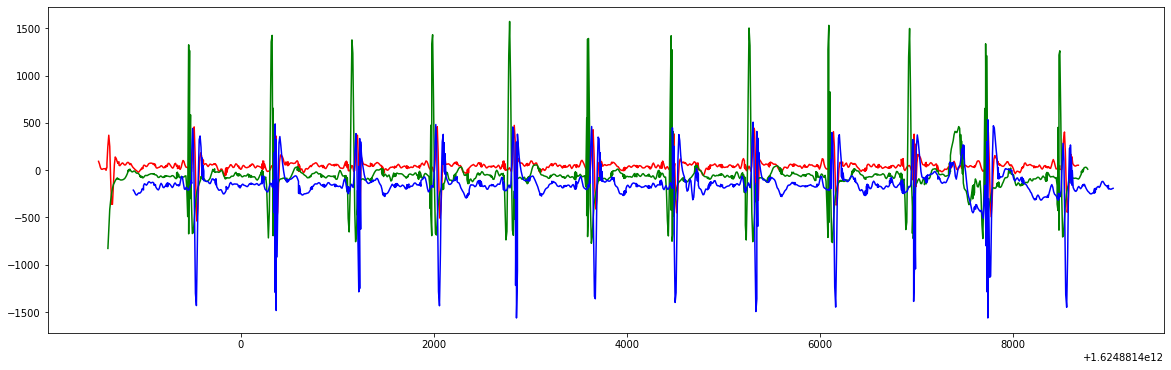

In [24]:
A=500
B=1800
for i in range(0, len(time_beg)):
    plt.plot(new_time1[i][A:B],new_data1[i][A:B]+100,'r-',new_time2[i][A:B], new_data2[0][A:B],'g-', new_time3[i][A:B],new_data3[i][A:B]-100,'b-')
    plt.show()

# Save data

In [25]:

timesample = np.array([])
dev_id = np.array([])
timestamp = np.array([])
ecg       = np.array([])


for i in range(0, len(time_beg)):
    n = len(new_data1[i]) + len(new_data2[i]) + len(new_data3[i])
    
    timesample = np.append(timesample, (i+1)*np.ones(n) ).astype(int)
    
    dev_id     = np.append(dev_id, 1*np.ones(len(new_data1[i]))).astype(int)
    dev_id     = np.append(dev_id, 2*np.ones(len(new_data2[i]))).astype(int)
    dev_id     = np.append(dev_id, 3*np.ones(len(new_data3[i]))).astype(int)
    
    timestamp = np.append(timestamp, new_time1[i])
    timestamp = np.append(timestamp, new_time2[i])
    timestamp = np.append(timestamp, new_time3[i])
    
    ecg = np.append(ecg, new_data1[i])
    ecg = np.append(ecg, new_data2[i])
    ecg = np.append(ecg, new_data3[i])
    
    ic(len(timesample))
    ic(len(dev_id))
    ic(len(timestamp))
    ic(len(ecg))
    
data = {"timesample":timesample, "dev_id": dev_id, "timestamp": timestamp, "ecg":ecg}
new_dataframe = pd.DataFrame(data) 
ic(new_dataframe)
new_dataframe.to_csv("ecg_data_sync2.csv",index=False,sep=';')

ic| len(timesample): 4172974
ic| len(dev_id): 4172974
ic| len(timestamp): 4172974
ic| len(ecg): 4172974
ic| new_dataframe:          timesample  dev_id     timestamp    ecg
                   0                 1       1  1.624881e+12   -1.0
                   1                 1       1  1.624881e+12   -2.0
                   2                 1       1  1.624881e+12   -2.0
                   3                 1       1  1.624881e+12  -14.0
                   4                 1       1  1.624881e+12   -4.0
                   ...             ...     ...           ...    ...
                   4172969           1       3  1.624892e+12 -143.0
                   4172970           1       3  1.624892e+12 -118.0
                   4172971           1       3  1.624892e+12  -95.0
                   4172972           1       3  1.624892e+12  -78.0
                   4172973           1       3  1.624892e+12  -73.0
                   
                   [4172974 rows x 4 columns]


In [26]:

timesample = np.array([])
dev_id = np.array([])
timestamp = np.array([])
x       = np.array([])
y       = np.array([])
z       = np.array([])


for i in range(0, len(time_beg)):
    n = len(new_time_acc[i])
    
    timesample = np.append(timesample, (i+1)*np.ones(n) ).astype(int)
    
    dev_id     = np.append(dev_id, 1*np.ones(n)).astype(int)
    
    timestamp = np.append(timestamp, new_time_acc[i])
    
    x = np.append(x, new_data_x_acc[i])
    y = np.append(y, new_data_y_acc[i])
    z = np.append(z, new_data_z_acc[i])
    
    
    
data = {"timesample":timesample, "dev_id": dev_id, "timestamp": timestamp, "x":x, "y":y, "z":z}
new_dataframe = pd.DataFrame(data) 
ic(new_dataframe)
new_dataframe.to_csv("acc_data_sync2.csv",index=False,sep=';')

ic| new_dataframe:          timesample  dev_id     timestamp         x         y         z
                   0                 1       1  1.624881e+12  0.007179  9.373021  3.335714
                   1                 1       1  1.624881e+12  0.000000  9.396950  3.318964
                   2                 1       1  1.624881e+12  0.028715  9.387379  3.383572
                   3                 1       1  1.624881e+12  0.059823  9.428058  3.287856
                   4                 1       1  1.624881e+12  0.021536  9.401736  3.366822
                   ...             ...     ...           ...       ...       ...       ...
                   1125979           1       1  1.624892e+12 -0.416366  8.624041  4.725994
                   1125980           1       1  1.624892e+12 -0.459438  8.652756  4.675743
                   1125981           1       1  1.624892e+12 -0.435509  8.650363  4.709243
                   1125982           1       1  1.624892e+12 -0.437902  8.659934  4.714029

In [27]:

timesample = np.array([])
dev_id = np.array([])
timestamp = np.array([])
x       = np.array([])
y       = np.array([])
z       = np.array([])


for i in range(0, len(time_beg)):
    n = len(new_time_gyro[i])
    
    timesample = np.append(timesample, (i+1)*np.ones(n) ).astype(int)
    
    dev_id     = np.append(dev_id, 1*np.ones(n)).astype(int)
    
    timestamp = np.append(timestamp, new_time_gyro[i])
    
    x = np.append(x, new_data_x_gyro[i])
    y = np.append(y, new_data_y_gyro[i])
    z = np.append(z, new_data_z_gyro[i])
    
    
    
data = {"timesample":timesample, "dev_id": dev_id, "timestamp": timestamp, "x":x, "y":y, "z":z}
new_dataframe = pd.DataFrame(data) 
ic(new_dataframe)
new_dataframe.to_csv("gyro_data_sync2.csv",index=False,sep=';')

ic| new_dataframe:          timesample  dev_id     timestamp     x     y     z
                   0                 1       1  1.624881e+12  4.97 -3.64  0.00
                   1                 1       1  1.624881e+12  4.76 -3.78 -0.07
                   2                 1       1  1.624881e+12  4.41 -3.92 -0.14
                   3                 1       1  1.624881e+12  4.34 -3.71 -0.14
                   4                 1       1  1.624881e+12  4.06 -3.36  0.00
                   ...             ...     ...           ...   ...   ...   ...
                   1125979           1       1  1.624892e+12  2.80  0.70  0.28
                   1125980           1       1  1.624892e+12  3.08  1.12  0.14
                   1125981           1       1  1.624892e+12  3.22  1.33  0.28
                   1125982           1       1  1.624892e+12  3.50  1.54  0.42
                   1125983           1       1  1.624892e+12  3.57  1.47  0.56
                   
                   [1125984 rows


timesample = np.array([])
dev_id = np.array([])
timestamp = np.array([])
x       = np.array([])
y       = np.array([])
z       = np.array([])


for i in range(0, len(time_beg)):
    n = len(new_time_magn[i])
    
    timesample = np.append(timesample, (i+1)*np.ones(n) ).astype(int)
    
    dev_id     = np.append(dev_id, 1*np.ones(n)).astype(int)
    
    timestamp = np.append(timestamp, new_time_magn[i])
    
    x = np.append(x, new_data_x_magn[i])
    y = np.append(y, new_data_y_magn[i])
    z = np.append(z, new_data_z_magn[i])
    
    
    
data = {"timesample":timesample, "dev_id": dev_id, "timestamp": timestamp, "x":x, "y":y, "z":z}
new_dataframe = pd.DataFrame(data) 
ic(new_dataframe)
new_dataframe.to_csv("magn_data_sync.csv",index=False,sep=';')